In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Literal
from sklearn.manifold import TSNE
from umap import UMAP
import itertools
from pathlib import Path
from loguru import logger

from histaug.extract_features import load_features

/app/env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/app/env/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was no

In [2]:
# model = "ctranspath"
# features = load_features(f"/app/results/kather100k_{model}.h5", remove_classes=["BACK"])

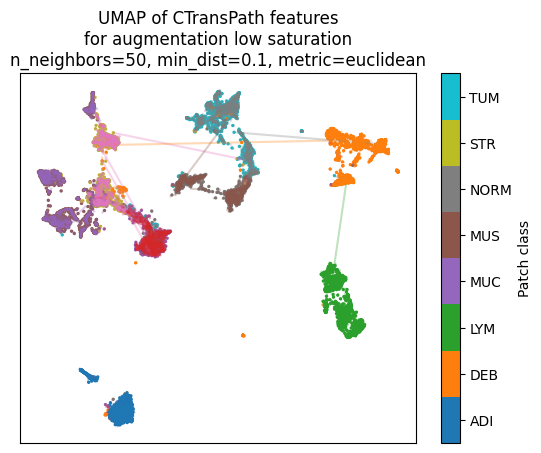

In [18]:
def visualize_embeddings(
    feats: np.ndarray,  # [n_samples, n_features]
    feats_aug: np.ndarray,  # [n_samples, n_features]
    labels: np.ndarray,  # [n_samples] (strings)
    augmentation: str,
    technique: Literal["tsne", "umap", "umap-separate"] = "tsne",
    metric: Literal["euclidean", "cosine", "manhattan"] = "euclidean",
    tsne_perplexity: int = 30,
    umap_n_neighbors: int = 50,
    umap_min_dist: float = 0.1,
):
    classes = sorted(np.unique(labels))
    label2class = {label: i for i, label in enumerate(classes)}
    fig = plt.figure()

    # Generate embeddings using t-SNE
    feats_cat = np.concatenate([feats, feats_aug], axis=0)
    if technique == "tsne":
        feats_embedded = TSNE(
            n_components=2,
            learning_rate="auto",
            init="pca",
            random_state=0,
            perplexity=tsne_perplexity,
            metric=metric,
        ).fit_transform(feats_cat)
        feats_embedded, feats_aug_embedded = np.split(feats_embedded, 2, axis=0)
    elif technique == "umap":
        feats_embedded = UMAP(
            n_components=2, random_state=0, n_neighbors=umap_n_neighbors, min_dist=umap_min_dist, metric=metric
        ).fit_transform(feats_cat)
        feats_embedded, feats_aug_embedded = np.split(feats_embedded, 2, axis=0)
    elif technique == "umap-separate":
        umap = UMAP(n_components=2, random_state=0, n_neighbors=umap_n_neighbors, min_dist=umap_min_dist, metric=metric)
        feats_embedded = umap.fit_transform(feats)
        feats_aug_embedded = umap.transform(feats_aug)

    # Use a colormap to map labels to colors
    cmap = matplotlib.colormaps["tab10"]  # 'tab10' is a colormap suitable for categorical data up to 10 categories

    # Draw lines and annotations
    for f, f_reflect, label in zip(feats_embedded, feats_aug_embedded, labels):
        # plt.plot([f[0], f_reflect[0]], [f[1], f_reflect[1]], c="k", alpha=0.1)
        plt.plot([f[0], f_reflect[0]], [f[1], f_reflect[1]], c=cmap.colors[label2class[label]], alpha=0.3)

    # Scatter plots
    plt.scatter(feats_embedded[:, 0], feats_embedded[:, 1], c=[label2class[l] for l in labels], s=2, cmap=cmap)

    # Add a colorbar to indicate which colors correspond to which labels
    cbar = plt.colorbar(boundaries=np.arange(len(classes) + 1) - 0.5)
    cbar.set_ticks(range(len(classes)))
    cbar.set_ticklabels(classes)
    cbar.set_label("Patch class")

    technique_kwargs = (
        dict(perplexity=tsne_perplexity)
        if technique == "tsne"
        else dict(n_neighbors=umap_n_neighbors, min_dist=umap_min_dist)
    )
    technique_kwargs["metric"] = metric
    technique_kwargs = ", ".join(f"{k}={v}" for k, v in technique_kwargs.items())
    plt.title(
        f"{'t-SNE' if technique == 'tsne' else 'UMAP'} of CTransPath features\nfor augmentation {augmentation}\n{technique_kwargs}"
    )
    plt.xticks([])
    plt.yticks([])

    return fig


# augmentation = "Macenko"
# augmentation = "low saturation"

# metric = "cosine"
# metric = "euclidean"
# # metric = "manhattan"

# N = 10000
# feats = features.feats[:N]
# feats_aug = features.feats_augs[augmentation][:N]
# labels = features.labels[:N]

# technique_kwargs = dict(
#     technique="tsne",
#     tsne_perplexity=30,
# )

# technique_kwargs = dict(
#     technique="umap",
#     umap_n_neighbors=50,
#     umap_min_dist=0.1,
# )

# visualize_embeddings(
#     feats=feats,
#     feats_aug=feats_aug,
#     labels=labels,
#     augmentation=augmentation,
#     metric=metric,
#     **technique_kwargs,
# )
# pass

In [ ]:
for model in "ctranspath", "swin", "retccl", "resnet":
    features = load_features(f"/app/results/kather100k_{model}.h5", remove_classes=["BACK"])

    N = 10000
    feats = features.feats[:N]
    feats_augs = {k: v[:N] for k, v in features.feats_augs.items()}
    labels = features.labels[:N]

    for metric in "cosine", "euclidean", "manhattan":
        for augmentation in "Macenko", "low saturation", "rotate random angle":
            for technique in "tsne", "umap":  # , "umap-separate":
                for kwargs in (
                    [dict(tsne_perplexity=p) for p in (3, 5, 10, 30, 50, 100, 1000, 5000)]
                    if technique == "tsne"
                    else [
                        dict(umap_min_dist=d, umap_n_neighbors=n)
                        for d, n in itertools.product((0.1, 0.5, 0.99), (3, 5, 10, 30, 50, 100, 1000, 5000))
                    ]
                ):
                    kwargs_str = ",".join(f"{k}={v}" for k, v in kwargs.items())
                    figures_dir = Path("/app/figures/visualize_embeddings")
                    figures_dir.mkdir(exist_ok=True)
                    output_file = (
                        figures_dir / f"{metric}-{technique}-{augmentation.replace(' ', '_')}-{kwargs_str}.png"
                    )

                    if output_file.exists():
                        logger.info(f"Skipping {output_file} as it already exists")
                        continue
                    logger.info(f"Visualizing {output_file}")
                    fig = visualize_embeddings(
                        feats,
                        feats_augs[augmentation],
                        labels,
                        augmentation,
                        technique=technique,
                        metric=metric,
                        **kwargs,
                    )
                    fig.savefig(output_file)
                    fig.tight_layout()
                    plt.close(fig)